In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit

datadir = f"./data/comparison"
plotdir = f"./plots/comparison"

if not os.path.exists(plotdir):
    os.makedirs(plotdir)


In [18]:
def prepare_performance(perf_df, algo_join_cols,last_task=10):
    # get stability plasticity and capacity
    stability_df = perf_df[(perf_df['phase'] == last_task) & (perf_df['task'] == 0)]
    plasticity_df = perf_df[(perf_df['phase'] == last_task) & (perf_df['task'] == last_task)]

    # drop columns manager, ridge result, run, index
    stability_df = stability_df.drop(columns=['manager', 'ridge_result', 'run', 'index'])
    plasticity_df = plasticity_df.drop(columns=['manager', 'ridge_result', 'run', 'index'])

    # rename cl_performance to plasticity and stability
    stability_df.rename(columns={'cl_result': 'stability'}, inplace=True)
    plasticity_df.rename(columns={'cl_result': 'plasticity'}, inplace=True)

    plasticity_df = plasticity_df.drop(columns=['task', 'phase'])
    stability_df = stability_df.drop(columns=['task', 'phase'])

    # merge both dataframes
    stability_plasticity_df = pd.merge(stability_df, plasticity_df, on=['tstamp', 'algorithm', 'dense_size'].extend(algo_join_cols))
    stability_plasticity_df['capacity'] = stability_plasticity_df['stability'] + stability_plasticity_df['plasticity']
    return stability_plasticity_df

def prepare_trajectories(filter_traj_df, last_task=10):
    run_names = filter_traj_df['run']
    run_names = run_names.str.split('_', expand=True)
    run_names['tstamp'] = run_names[0]
    filter_traj_df = filter_traj_df.drop(columns=['run'])
    filter_traj_df['tstamp'] = run_names['tstamp']
    filter_traj_df = filter_traj_df.reset_index()
    filter_traj_df_last = filter_traj_df[filter_traj_df['phase'] == last_task]
    distances_to_first = filter_traj_df_last[['tstamp', 'distance_to_first_null_space', 'distance_to_first_in_plane']]
    filter_traj_df = filter_traj_df.drop(columns=['distance_to_first_null_space', 'distance_to_first_in_plane', 'phase', 'index'])

    # group by tstamp
    filter_traj_df_grp = filter_traj_df.groupby(['tstamp'])
    distances_cumulative = filter_traj_df_grp.sum(numeric_only=True).reset_index()

    # join on tstamp
    distance_df = pd.merge(distances_cumulative, distances_to_first, on=['tstamp'])
    return distance_df

def join_frames(distance_df, perf_df):
    # tstamps are floats
    distance_df['tstamp'] = distance_df['tstamp'].astype(float)
    perf_df['tstamp'] = perf_df['tstamp'].astype(float)

    # sort both frames by ascending tstamp
    distance_df = distance_df.sort_values(by=['tstamp'])
    perf_df = perf_df.sort_values(by=['tstamp'])

    # rename tstamps to tstamp_d and tstamp_s
    distance_df.rename(columns={'tstamp': 'tstamp_d'}, inplace=True)
    perf_df.rename(columns={'tstamp': 'tstamp_s'}, inplace=True)

    # reset indicees and drop index
    distance_df = distance_df.reset_index()
    distance_df = distance_df.drop(columns=['index'])

    perf_df = perf_df.reset_index()
    perf_df = perf_df.drop(columns=['index'])

    # concatenate both dataframes along the columns
    combined_df = pd.concat([distance_df, perf_df], axis=1)
    return combined_df

In [19]:
############################### EWC
ewc_performance_path = f"{datadir}/ewc_cifar110/performance.csv"
ewc_trajectories_filter_path = f"{datadir}/ewc_cifar110/filtered_trajectories_ewc_plasticity_cifar110_nodrop_task_0_relu_fc1.pkl"

ewc_perf_df = pd.read_csv(ewc_performance_path)
ewc_trajectories_filter = pd.read_pickle(ewc_trajectories_filter_path)

############################### SI
si_performance_path = f"{datadir}/si_cifar110/performance.csv"
si_trajectories_filter_path = f"{datadir}/si_cifar110/filtered_trajectories_si_plasticity_cifar110_nodrop_task_0_relu_fc1.pkl"

si_perf_df = pd.read_csv(si_performance_path)
si_trajectories_filter = pd.read_pickle(si_trajectories_filter_path)

############################### Replay fixed readout
replay_perf_path = f"{datadir}/replay_fixed_readout/performance.csv"
replay_trajectories_filter_path = f"{datadir}/si_cifar110/filtered_trajectories_si_plasticity_cifar110_nodrop_task_0_relu_fc1.pkl"

replay_perf_df = pd.read_csv(replay_perf_path)
replay_trajectories_filter = pd.read_pickle(replay_trajectories_filter_path)

replay_perf_path = f"{datadir}/replay_fixed_readout/performance_high.csv"
replay_trajectories_filter_path = f"{datadir}/replay_fixed_readout/filtered_trajectories_replay_plasticity_cifar110_frozen_readouts_high_task_0_relu_fc1.pkl"

replay_perf_df2 = pd.read_csv(replay_perf_path)
replay_trajectories_filter2 = pd.read_pickle(replay_trajectories_filter_path)

replay_perf_df = pd.concat([replay_perf_df, replay_perf_df2])
replay_trajectories_filter = pd.concat([replay_trajectories_filter, replay_trajectories_filter2])

############################### GEM
gem_performance_path = f"{datadir}/gem_buf_cifar110/performance.csv"
gem_trajectories_filter_path = f"{datadir}/gem_buf_cifar110/filtered_trajectories_gem_sweep_buffersize_task_0_relu_fc1.pkl"

gem_perf_df = pd.read_csv(gem_performance_path)
gem_trajectories_filter = pd.read_pickle(gem_trajectories_filter_path)

gem_performance_path = f"{datadir}/gem_cifar110/performance.csv"
gem_trajectories_filter_path = f"{datadir}/gem_cifar110/filtered_trajectories_cifar110_nodrop_task_0_relu_fc1.pkl"

gem_perf_df2 = pd.read_csv(gem_performance_path)
gem_trajectories_filter2 = pd.read_pickle(gem_trajectories_filter_path)

gem_performance_path = f"{datadir}/gem_high_cifar110/performance.csv"
gem_trajectories_filter_path = f"{datadir}/gem_high_cifar110/filtered_trajectories_cifar110_gem_capacity_exp_nodrop_augment_high_buf_task_0_relu_fc1.pkl"

gem_perf_df3 = pd.read_csv(gem_performance_path)
gem_trajectories_filter3 = pd.read_pickle(gem_trajectories_filter_path)


gem_perf_df = pd.concat([gem_perf_df, gem_perf_df2, gem_perf_df3])
gem_trajectories_filter = pd.concat([gem_trajectories_filter, gem_trajectories_filter2, gem_trajectories_filter3])

############################### LwF

lwf_performance_path = f"{datadir}/lwf_cifar110/performance.csv"
lwf_trajectories_filter = f"{datadir}/lwf_cifar110/filtered_trajectories_lwf_plasticity_cifar110_frozen_readouts_task_0_relu_fc1.pkl"

lwf_perf_df = pd.read_csv(lwf_performance_path)
lwf_trajectories_filter = pd.read_pickle(lwf_trajectories_filter)

lwf_performance_path = f"{datadir}/lwf_cifar110/performance_temp.csv"
lwf_trajectories_filter_path = f"{datadir}/lwf_cifar110/filtered_trajectories_temp_lwf_task_0_relu_fc1.pkl"

lwf_perf_df2 = pd.read_csv(lwf_performance_path)
lwf_trajectories_filter2 = pd.read_pickle(lwf_trajectories_filter_path)

lwf_perf_df = pd.concat([lwf_perf_df, lwf_perf_df2])
lwf_trajectories_filter = pd.concat([lwf_trajectories_filter, lwf_trajectories_filter2])

In [20]:
distance_df_ewc = prepare_trajectories(ewc_trajectories_filter)
perf_df_ewc = prepare_performance(ewc_perf_df, ['ewc_lambda'])
combined_df_ewc = join_frames(distance_df_ewc, perf_df_ewc)

distance_df_si = prepare_trajectories(si_trajectories_filter)
perf_df_si = prepare_performance(si_perf_df, ['si_lambda', 'si_eps'])
combined_df_si = join_frames(distance_df_si, perf_df_si)

distance_df_replay = prepare_trajectories(replay_trajectories_filter)
perf_df_replay = prepare_performance(replay_perf_df, ['replay_mem_size'])
combined_df_replay = join_frames(distance_df_replay, perf_df_replay)
combined_df_replay = combined_df_replay[combined_df_replay['replay_mem_size'] <= 60000]  # remove unreasonably large replay mem sizes

distance_df_gem = prepare_trajectories(gem_trajectories_filter)
perf_df_gem = prepare_performance(gem_perf_df, ['gem_memory_strength', 'gem_patterns_per_experience'])
combined_df_gem = join_frames(distance_df_gem, perf_df_gem)

distance_df_lwf = prepare_trajectories(lwf_trajectories_filter)
perf_df_lwf = prepare_performance(lwf_perf_df, ['lwf_alpha', 'lwf_temperature'])
combined_df_lwf = join_frames(distance_df_lwf, perf_df_lwf)

/Users/daniel/miniconda3/envs/pt/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/daniel/miniconda3/envs/pt/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/daniel/miniconda3/envs/pt/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/daniel/miniconda3/envs/pt/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/daniel/miniconda3/envs/pt/lib/python3.10/

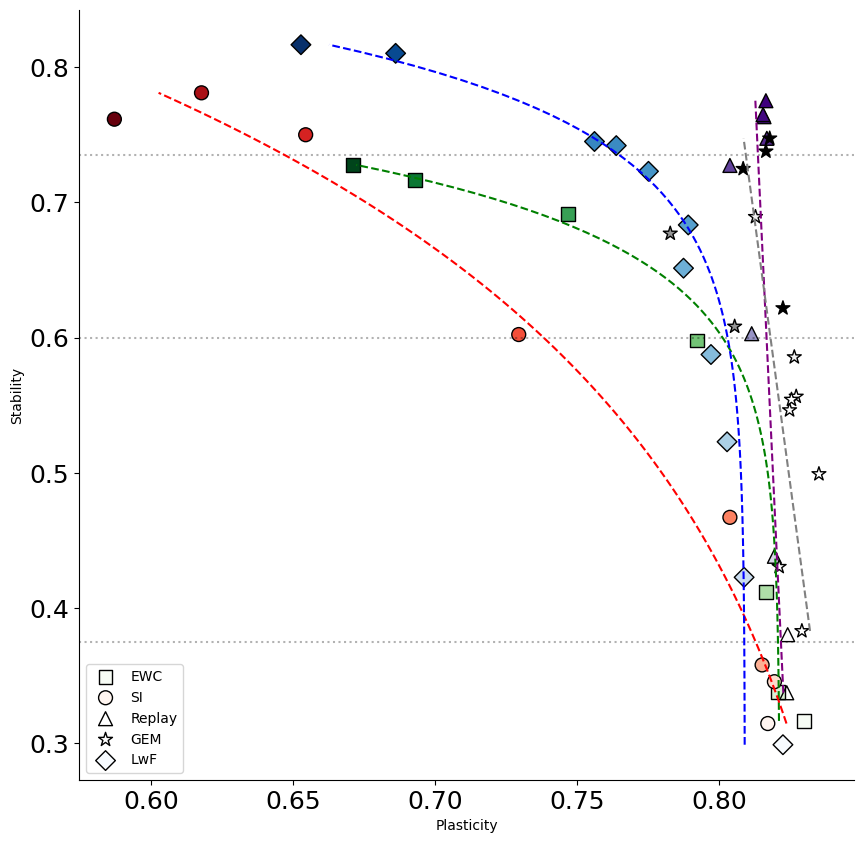

In [21]:
DENSE_SIZE = 128
SI_EPS = 1.
LWF_TEMP = 1.
MARKER_SIZE = 100
REFERENCE_STABILITIES = [.375, .6, .735]

def func(x, a, b, c, d):
    # 3rd order polynomial
    return a + b * np.exp(c * x)

plt.figure(figsize=(10,10))
# vertical line at ref
for REFERENCE_STABILITY in REFERENCE_STABILITIES:
    plt.axhline(y=REFERENCE_STABILITY, linestyle='dotted', color='k', alpha=.3)

########## EWC
    
df = combined_df_ewc[combined_df_ewc['dense_size'] == DENSE_SIZE]
df = df.groupby(['ewc_lambda']).mean(numeric_only=True).reset_index()
log_norm_ewc = LogNorm(vmin=df['ewc_lambda'].min(), vmax=df['ewc_lambda'].max())

popt, pcov = curve_fit(func, df['stability'], df['plasticity'], p0=(1, 1, 10, 0))
x = np.linspace(df['stability'].min(), df['stability'].max(), 100)
plt.plot(func(x, *popt), x, 'g--')

plt.scatter(df['plasticity'],
            df['stability'],
            c=df['ewc_lambda'],
            cmap='Greens',
            norm=log_norm_ewc,
            s=MARKER_SIZE,
            marker='s',
            edgecolors='k',
            linewidths=1,
            label='EWC'
            )

########## SI
df = combined_df_si[combined_df_si['dense_size'] == DENSE_SIZE]
df = df[df['si_eps'] == SI_EPS]
df = df.groupby(['si_lambda']).mean(numeric_only=True).reset_index()

x = np.linspace(df['stability'].min(), df['stability'].max(), 100)
popt, pcov = curve_fit(func, df['stability'], df['plasticity'], p0=(1, 1, 10, 0))
plt.plot(func(x, *popt), x, 'r--')

norm = LogNorm(vmin=df['si_lambda'].min(), vmax=df['si_lambda'].max())
plt.scatter(df['plasticity'],
            df['stability'],
            c=df['si_lambda'],
            cmap='Reds',
            norm=norm,
            s=MARKER_SIZE,
            marker='o',
            edgecolors='k',
            linewidths=1,
            label='SI'
            )

########## Replay
df = combined_df_replay[combined_df_replay['dense_size'] == DENSE_SIZE]
df = df.groupby(['replay_mem_size']).mean(numeric_only=True).reset_index()

# fit poly
x = np.linspace(df['stability'].min(), df['stability'].max(), 100)
popt, pcov = curve_fit(func, df['stability'], df['plasticity'], p0=(1,0,0,0))
plt.plot(func(x, *popt), x, 'purple', linestyle='--')


plt.scatter(df['plasticity'],
            df['stability'],
            c=df['replay_mem_size'],
            cmap='Purples',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='Replay',
            marker='^'
            )

########## gem
df = combined_df_gem[combined_df_gem['dense_size'] == DENSE_SIZE]
# df = df[df['gem_patterns_per_experience'] == GEM_PATTERNS]
df = df[df['gem_memory_strength'] >= 0.]
df = df.groupby(['gem_patterns_per_experience', 'gem_memory_strength']).mean(numeric_only=True).reset_index()

# fit poly
x = np.linspace(df['stability'].min(), df['stability'].max(), 100)
popt, pcov = curve_fit(func, df['stability'], df['plasticity'], p0=(1,0,0,0))
plt.plot(func(x, *popt), x, 'gray', linestyle='--')


plt.scatter(df['plasticity'],
            df['stability'],
            c=df['gem_memory_strength'],
            cmap='Greys',
            s=MARKER_SIZE + 10,  # stars looks smaller
            edgecolors='k',
            linewidths=1,
            label='GEM',
            marker='*'
)

########## lwf
df = combined_df_lwf[combined_df_lwf['dense_size'] == DENSE_SIZE]
df = df[df['lwf_temperature'] == LWF_TEMP]
df = df.groupby(['lwf_alpha']).mean(numeric_only=True).reset_index()

# fit poly
x = np.linspace(df['stability'].min(), df['stability'].max(), 100)
popt, pcov = curve_fit(func, df['stability'], df['plasticity'], p0=(1,0,1,10))
plt.plot(func(x, *popt), x, 'blue', linestyle='--')

plt.scatter(df['plasticity'],
            df['stability'],
            c=df['lwf_alpha'],
            cmap='Blues',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='LwF',
            marker='D'
            )

plt.legend()
plt.xlabel('Plasticity')
plt.ylabel('Stability')
sns.despine()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig(f'{plotdir}/plasticity_vs_stability_128_units_new.png', bbox_inches='tight')




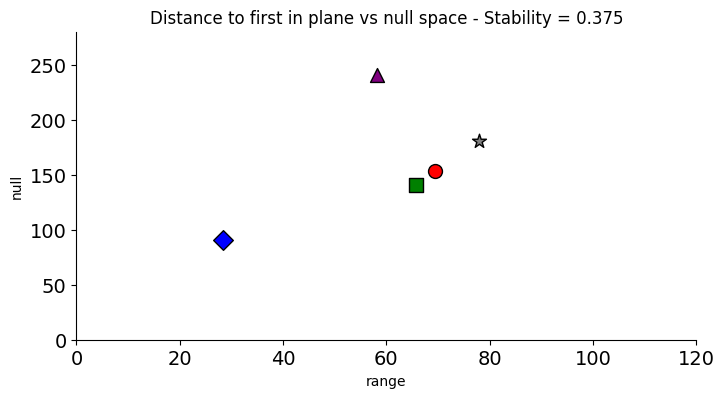

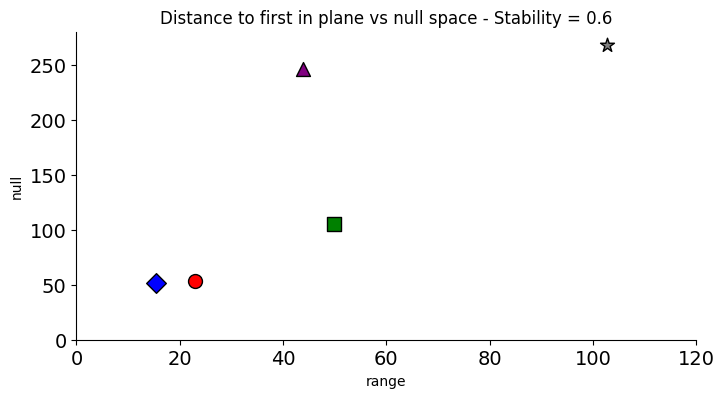

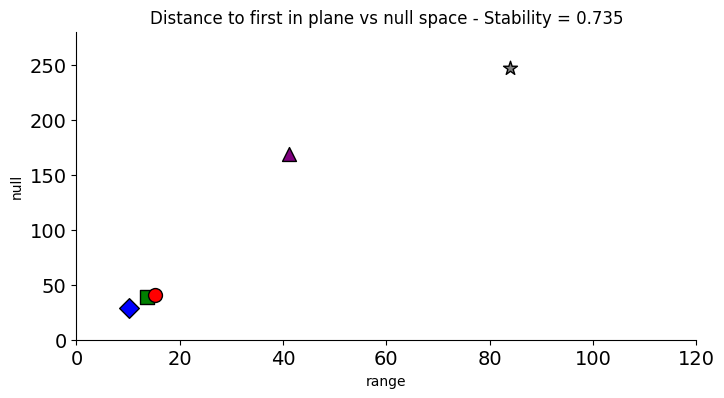

In [22]:
# for each algorithm, get closest mean stability to reference stability and parameters

def get_closest_stability(avg_df, reference_stability):
    # get closest stability to reference stability
    avg_df['distance_to_reference'] = abs(avg_df['stability'] - reference_stability)
    avg_df = avg_df.sort_values(by=['distance_to_reference'])
    closest_stability = avg_df.iloc[0]
    return closest_stability

for REFERENCE_STABILITY in REFERENCE_STABILITIES:
    # EWC
    df = combined_df_ewc[combined_df_ewc['dense_size'] == DENSE_SIZE]
    df = df.groupby(['ewc_lambda']).mean(numeric_only=True).reset_index()
    closest_stability_ewc = get_closest_stability(df, REFERENCE_STABILITY)
    # collect runs
    ewc_ref_runs = combined_df_ewc[(combined_df_ewc['dense_size'] == DENSE_SIZE) & (combined_df_ewc['ewc_lambda'] == closest_stability_ewc['ewc_lambda'])]
    # SI
    df = combined_df_si[combined_df_si['dense_size'] == DENSE_SIZE]
    df = df[df['si_eps'] == SI_EPS]
    df = df.groupby(['si_lambda']).mean(numeric_only=True).reset_index()
    closest_stability_si = get_closest_stability(df, REFERENCE_STABILITY)
    # collect runs
    si_ref_runs = combined_df_si[(combined_df_si['dense_size'] == DENSE_SIZE) & (combined_df_si['si_eps'] == SI_EPS) & (combined_df_si['si_lambda'] == closest_stability_si['si_lambda'])]
    # Replay
    df = combined_df_replay[combined_df_replay['dense_size'] == DENSE_SIZE]
    df = df.groupby(['replay_mem_size']).mean(numeric_only=True).reset_index()
    closest_stability_replay = get_closest_stability(df, REFERENCE_STABILITY)
    # collect runs
    replay_ref_runs = combined_df_replay[(combined_df_replay['dense_size'] == DENSE_SIZE) & (combined_df_replay['replay_mem_size'] == closest_stability_replay['replay_mem_size'])]
    # gem
    df = combined_df_gem[combined_df_gem['dense_size'] == DENSE_SIZE]
    df = df[df['gem_memory_strength'] >= 0]
    df = df.groupby(['gem_patterns_per_experience', 'gem_memory_strength']).mean(numeric_only=True).reset_index()
    closest_stability_gem = get_closest_stability(df, REFERENCE_STABILITY)
    # collect runs
    gem_ref_runs = combined_df_gem[(combined_df_gem['dense_size'] == DENSE_SIZE) & (combined_df_gem['gem_memory_strength'] == closest_stability_gem['gem_memory_strength']) & (combined_df_gem['gem_patterns_per_experience'] == closest_stability_gem['gem_patterns_per_experience'])]
    # lwf
    df = combined_df_lwf[combined_df_lwf['dense_size'] == DENSE_SIZE]
    df = df.groupby(['lwf_alpha', 'lwf_temperature']).mean(numeric_only=True).reset_index()
    closest_stability_lwf = get_closest_stability(df, REFERENCE_STABILITY)
    # collect runs
    lwf_ref_runs = combined_df_lwf[(combined_df_lwf['dense_size'] == DENSE_SIZE) & (combined_df_lwf['lwf_alpha'] == closest_stability_lwf['lwf_alpha']) & (combined_df_lwf['lwf_temperature'] == closest_stability_lwf['lwf_temperature'])]

    # force a copy of all dfs
    ewc_ref_runs = ewc_ref_runs.copy()
    si_ref_runs = si_ref_runs.copy()
    replay_ref_runs = replay_ref_runs.copy()
    gem_ref_runs = gem_ref_runs.copy()
    lwf_ref_runs = lwf_ref_runs.copy()

    # concatenate all runs after adding algorithm column
    ewc_ref_runs['algorithm'] = 'EWC'
    si_ref_runs['algorithm'] = 'SI'
    replay_ref_runs['algorithm'] = 'Replay'
    gem_ref_runs['algorithm'] = 'GEM'
    lwf_ref_runs['algorithm'] = 'LwF'

    # concatenate all runs
    ref_runs = pd.concat([ewc_ref_runs, si_ref_runs, replay_ref_runs, gem_ref_runs, lwf_ref_runs])
    # select algorithm and distances
    ref_runs = ref_runs[['algorithm', 'distance_to_first_null_space', 'distance_to_first_in_plane']]
    # avg over algorithm
    ref_runs = ref_runs.groupby(['algorithm']).mean(numeric_only=True).reset_index()
    plt.figure(figsize=(8,4))

    # ewc
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'EWC']['distance_to_first_in_plane'],
        ref_runs[ref_runs['algorithm'] == 'EWC']['distance_to_first_null_space'],
        c='g',
        s=MARKER_SIZE,
        marker='s',
        edgecolors='k',
        linewidths=1,
        label='EWC'
    )

    # SI
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'SI']['distance_to_first_in_plane'],
        ref_runs[ref_runs['algorithm'] == 'SI']['distance_to_first_null_space'],
        c='r',
        s=MARKER_SIZE,
        marker='o',
        edgecolors='k',
        linewidths=1,
        label='SI'
    )

    # Replay
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'Replay']['distance_to_first_in_plane'],
        ref_runs[ref_runs['algorithm'] == 'Replay']['distance_to_first_null_space'],
        c='purple',
        s=MARKER_SIZE,
        marker='^',
        edgecolors='k',
        linewidths=1,
        label='Replay'
    )

    # GEM
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'GEM']['distance_to_first_in_plane'],
        ref_runs[ref_runs['algorithm'] == 'GEM']['distance_to_first_null_space'],
        c='grey',
        s=MARKER_SIZE + 10,
        marker='*',
        edgecolors='k',
        linewidths=1,
        label='GEM'
    )

    # LwF
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'LwF']['distance_to_first_in_plane'],
        ref_runs[ref_runs['algorithm'] == 'LwF']['distance_to_first_null_space'],
        c='blue',
        s=MARKER_SIZE,
        marker='D',
        edgecolors='k',
        linewidths=1,
        label='LwF'
    )

    # add a dotted line through the origin with slope sqrt(10/118)
    # x = np.linspace(0, 250, 100)
    # y = np.sqrt(10/118) * x
    # plt.plot(x, y, 'k--', alpha=.5)

    # set text sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.legend(fontsize=14)

    plt.title(f'Distance to first in plane vs null space - Stability = {REFERENCE_STABILITY}')
    plt.xlabel('range')
    plt.ylabel('null')
    sns.despine()
    # equal axes
    # plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim([0, 120])
    plt.ylim([0, 280])
    # plt.savefig(f'{plotdir}/distance_to_first_in_plane_vs_null_space_{REFERENCE_STABILITY}.png', bbox_inches='tight')


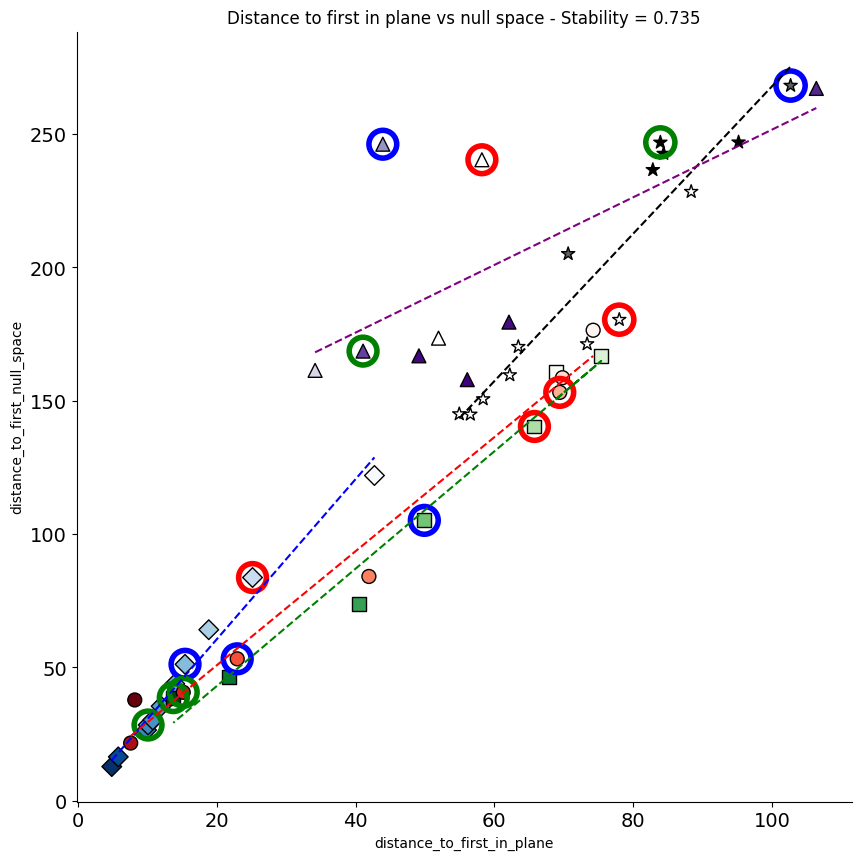

In [23]:
def get_closest_stability(avg_df, reference_stability):
    # get closest stability to reference stability
    avg_df['distance_to_reference'] = abs(avg_df['stability'] - reference_stability)
    avg_df = avg_df.sort_values(by=['distance_to_reference'])
    closest_stability = avg_df.iloc[0]
    return closest_stability


# plot distance in null vs distance in range
X = 'distance_to_first_in_plane'
Y = 'distance_to_first_null_space'

plt.figure(figsize=(10,10))

# lwf
df = combined_df_lwf[combined_df_lwf['dense_size'] == DENSE_SIZE]
df = df[df['lwf_temperature'] == LWF_TEMP]
df = df.groupby(['lwf_alpha', 'lwf_temperature']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
plt.plot(df[X], slope * df[X] + intercept, '--', c='blue')


plt.scatter(df[X],
            df[Y],
            c=df['lwf_alpha'],
            cmap='Blues',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='LwF',
            marker='D'
            )

# ewc
df = combined_df_ewc[combined_df_ewc['dense_size'] == DENSE_SIZE]
df = df.groupby(['ewc_lambda']).mean(numeric_only=True).reset_index()
slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
plt.plot(df[X], slope * df[X] + intercept, '--', c='green')
log_norm_ewc = LogNorm(vmin=df['ewc_lambda'].min(), vmax=df['ewc_lambda'].max())
plt.scatter(x=df[X],
            y=df[Y],
            c=df['ewc_lambda'],
            cmap='Greens',
            norm=log_norm_ewc,
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            marker='s',
            label='EWC',
            )

# SI
df = combined_df_si[combined_df_si['dense_size'] == DENSE_SIZE]
df = df[df['si_eps'] == SI_EPS]
df = df.groupby(['si_lambda']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
plt.plot(df[X], slope * df[X] + intercept, '--', c='red')

norm = LogNorm(vmin=df['si_lambda'].min(), vmax=df['si_lambda'].max())
plt.scatter(df[X],
            df[Y],
            c=df['si_lambda'],
            cmap='Reds',
            norm=norm,
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='SI',
            )

# gem
df = combined_df_gem[combined_df_gem['dense_size'] == DENSE_SIZE]
df = df[df['gem_memory_strength'] >= 0]
df = df.groupby(['gem_patterns_per_experience', 'gem_memory_strength']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
plt.plot(df[X], slope * df[X] + intercept, '--', c='k')


plt.scatter(df[X],
            df[Y],
            c=df['gem_memory_strength'],
            cmap='Greys',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='GEM',
            marker='*'
            )

# replay
df = combined_df_replay[combined_df_replay['dense_size'] == DENSE_SIZE]
df = df.groupby(['replay_mem_size']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])
# regression line
slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
plt.plot(df[X], slope * df[X] + intercept, '--', c='purple')

plt.scatter(df[X],
            df[Y],
            c=df['replay_mem_size'],
            cmap='Purples',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='Replay',
            marker='^'
            )


# plt.legend()

# axis labels
plt.xlabel(X)
plt.ylabel(Y)
# equal axes
# plt.gca().set_aspect('equal', adjustable='box')
# despine
sns.despine()

# increase size of tick font
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# x = np.linspace(0, 270, 100)
# y = np.sqrt(10/118) * x
# plt.plot(x, y, linestyle='dotted', c='k', alpha=.5)

# plt.savefig(f'{plotdir}/distance_to_first_in_plane_vs_null_space.png', bbox_inches='tight')

REFCOLORS = ['red', 'blue', 'green', 'purple']
for REFERENCE_STABILITY, REF_COLOR in zip(REFERENCE_STABILITIES, REFCOLORS):

    # EWC
    df = combined_df_ewc[combined_df_ewc['dense_size'] == DENSE_SIZE]
    df = df.groupby(['ewc_lambda']).mean(numeric_only=True).reset_index()
    closest_stability_ewc = get_closest_stability(df, REFERENCE_STABILITY)
    ewc_ref_runs = combined_df_ewc[(combined_df_ewc['dense_size'] == DENSE_SIZE) & (combined_df_ewc['ewc_lambda'] == closest_stability_ewc['ewc_lambda'])]

    # SI
    df = combined_df_si[combined_df_si['dense_size'] == DENSE_SIZE]
    df = df[df['si_eps'] == SI_EPS]
    df = df.groupby(['si_lambda']).mean(numeric_only=True).reset_index()
    closest_stability_si = get_closest_stability(df, REFERENCE_STABILITY)
    si_ref_runs = combined_df_si[(combined_df_si['dense_size'] == DENSE_SIZE) & (combined_df_si['si_eps'] == SI_EPS) & (combined_df_si['si_lambda'] == closest_stability_si['si_lambda'])]

    # Replay
    df = combined_df_replay[combined_df_replay['dense_size'] == DENSE_SIZE]
    df = df.groupby(['replay_mem_size']).mean(numeric_only=True).reset_index()
    closest_stability_replay = get_closest_stability(df, REFERENCE_STABILITY)
    replay_ref_runs = combined_df_replay[(combined_df_replay['dense_size'] == DENSE_SIZE) & (combined_df_replay['replay_mem_size'] == closest_stability_replay['replay_mem_size'])]

    # gem
    df = combined_df_gem[combined_df_gem['dense_size'] == DENSE_SIZE]
    df = df[df['gem_memory_strength'] >= 0]
    df = df.groupby(['gem_patterns_per_experience', 'gem_memory_strength']).mean(numeric_only=True).reset_index()
    closest_stability_gem = get_closest_stability(df, REFERENCE_STABILITY)
    gem_ref_runs = combined_df_gem[(combined_df_gem['dense_size'] == DENSE_SIZE) & (combined_df_gem['gem_memory_strength'] == closest_stability_gem['gem_memory_strength']) & (combined_df_gem['gem_patterns_per_experience'] == closest_stability_gem['gem_patterns_per_experience'])]

    # lwf
    df = combined_df_lwf[combined_df_lwf['dense_size'] == DENSE_SIZE]
    df = df[df['lwf_temperature'] == LWF_TEMP]
    df = df.groupby(['lwf_alpha', 'lwf_temperature']).mean(numeric_only=True).reset_index()
    closest_stability_lwf = get_closest_stability(df, REFERENCE_STABILITY)
    lwf_ref_runs = combined_df_lwf[(combined_df_lwf['dense_size'] == DENSE_SIZE) & (combined_df_lwf['lwf_alpha'] == closest_stability_lwf['lwf_alpha']) & (combined_df_lwf['lwf_temperature'] == closest_stability_lwf['lwf_temperature'])]

    # force a copy of all dfs
    ewc_ref_runs = ewc_ref_runs.copy()
    si_ref_runs = si_ref_runs.copy()
    replay_ref_runs = replay_ref_runs.copy()
    gem_ref_runs = gem_ref_runs.copy()
    lwf_ref_runs = lwf_ref_runs.copy()

    # concatenate all runs after adding algorithm column
    ewc_ref_runs['algorithm'] = 'EWC'
    si_ref_runs['algorithm'] = 'SI'
    replay_ref_runs['algorithm'] = 'Replay'
    gem_ref_runs['algorithm'] = 'GEM'
    lwf_ref_runs['algorithm'] = 'LwF'

    # concatenate all runs
    ref_runs = pd.concat([ewc_ref_runs, si_ref_runs, replay_ref_runs, gem_ref_runs, lwf_ref_runs])
    # select algorithm and distances
    ref_runs = ref_runs[['algorithm', 'distance_to_first_null_space', 'distance_to_first_in_plane']]
    # avg over algorithm
    ref_runs = ref_runs.groupby(['algorithm']).mean(numeric_only=True).reset_index()
    
    # ewc
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'EWC'][X],
        ref_runs[ref_runs['algorithm'] == 'EWC'][Y],
        s=MARKER_SIZE * 4,
        marker='o',
        edgecolors=REF_COLOR,
        linewidths=4,
        facecolors='none',
        label='EWC'
    )

    # SI
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'SI'][X],
        ref_runs[ref_runs['algorithm'] == 'SI'][Y],
        s=MARKER_SIZE * 4,
        marker='o',
        edgecolors=REF_COLOR,
        linewidths=4,
        facecolors='none',
        label='SI'
    )

    # Replay
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'Replay'][X],
        ref_runs[ref_runs['algorithm'] == 'Replay'][Y],
        s=MARKER_SIZE * 4,
        marker='o',
        edgecolors=REF_COLOR,
        linewidths=4,
        facecolors='none',
        label='Replay'
    )
    
    # GEM
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'GEM'][X],
        ref_runs[ref_runs['algorithm'] == 'GEM'][Y],
        s=(MARKER_SIZE + 10) * 4,
        marker='o',
        edgecolors=REF_COLOR,
        linewidths=4,
        facecolors='none',
        label='GEM'
    )

    # LwF
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'LwF'][X],
        ref_runs[ref_runs['algorithm'] == 'LwF'][Y],
        s=MARKER_SIZE * 4,
        marker='o',
        edgecolors=REF_COLOR,
        linewidths=4,
        facecolors='none',
        label='LwF'
    )

    # add a dotted line through the origin with slope sqrt(10/118)
    # x = np.linspace(0, 250, 100)
    # y = np.sqrt(10/118) * x
    # plt.plot(x, y, 'k--', alpha=.5)

    # set text sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.legend(fontsize=14)

    plt.title(f'Distance to first in plane vs null space - Stability = {REFERENCE_STABILITY}')
    plt.xlabel(X)
    plt.ylabel(Y)
    sns.despine()
    # equal axes
    # plt.gca().set_aspect('equal', adjustable='box')
    # plt.xlim([0, 120])
    # plt.ylim([0, 280])
plt.savefig(f'{plotdir}/distance_to_first_in_plane_vs_null_space_references.png', bbox_inches='tight')


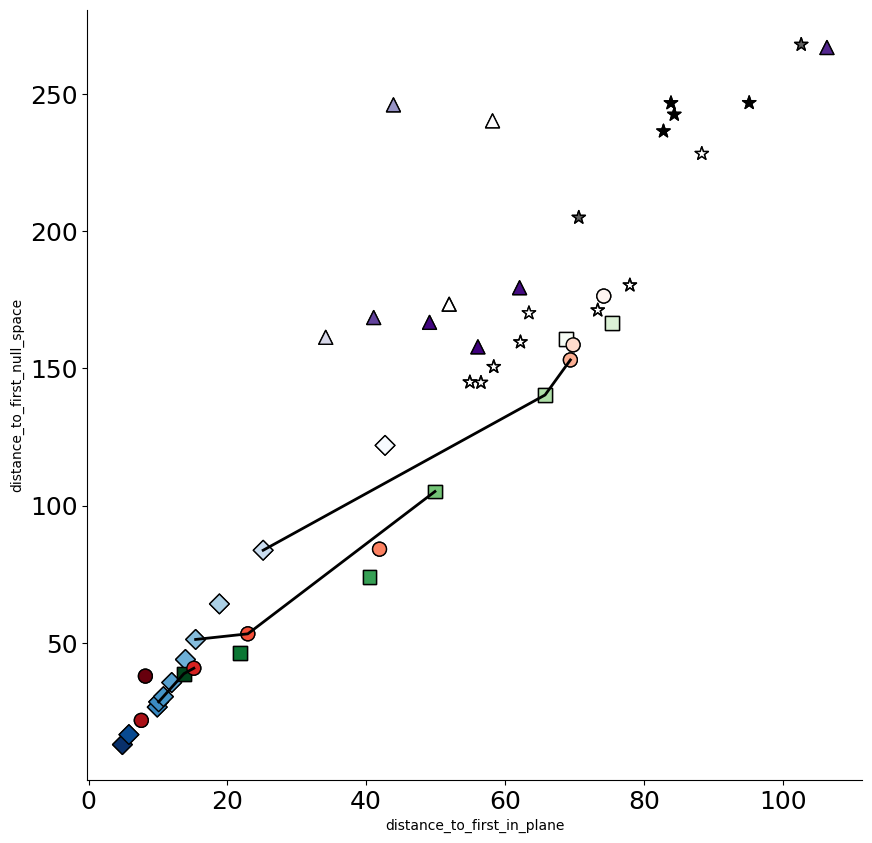

In [24]:
# plot distance in null vs distance in range
X = 'distance_to_first_in_plane'
Y = 'distance_to_first_null_space'

plt.figure(figsize=(10,10))

# lwf
df = combined_df_lwf[combined_df_lwf['dense_size'] == DENSE_SIZE]
df = df[df['lwf_temperature'] == LWF_TEMP]
df = df.groupby(['lwf_alpha', 'lwf_temperature']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
# slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
# plt.plot(df[X], slope * df[X] + intercept, '--', c='blue')

plt.scatter(df[X],
            df[Y],
            c=df['lwf_alpha'],
            cmap='Blues',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='LwF',
            marker='D'
            )

# ewc
df = combined_df_ewc[combined_df_ewc['dense_size'] == DENSE_SIZE]
df = df.groupby(['ewc_lambda']).mean(numeric_only=True).reset_index()
# slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
# plt.plot(df[X], slope * df[X] + intercept, '--', c='green')

log_norm_ewc = LogNorm(vmin=df['ewc_lambda'].min(), vmax=df['ewc_lambda'].max())
plt.scatter(x=df[X],
            y=df[Y],
            c=df['ewc_lambda'],
            cmap='Greens',
            norm=log_norm_ewc,
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            marker='s',
            label='EWC',
            )

# SI
df = combined_df_si[combined_df_si['dense_size'] == DENSE_SIZE]
df = df[df['si_eps'] == SI_EPS]
df = df.groupby(['si_lambda']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
# slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
# plt.plot(df[X], slope * df[X] + intercept, '--', c='red')

norm = LogNorm(vmin=df['si_lambda'].min(), vmax=df['si_lambda'].max())
plt.scatter(df[X],
            df[Y],
            c=df['si_lambda'],
            cmap='Reds',
            norm=norm,
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='SI',
            )

# gem
df = combined_df_gem[combined_df_gem['dense_size'] == DENSE_SIZE]
df = df[df['gem_memory_strength'] >= 0]
df = df.groupby(['gem_patterns_per_experience', 'gem_memory_strength']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
# slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
# plt.plot(df[X], slope * df[X] + intercept, '--', c='k')

plt.scatter(df[X],
            df[Y],
            c=df['gem_memory_strength'],
            cmap='Greys',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='GEM',
            marker='*'
            )

# replay
df = combined_df_replay[combined_df_replay['dense_size'] == DENSE_SIZE]
df = df.groupby(['replay_mem_size']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])
# regression line
# slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
# plt.plot(df[X], slope * df[X] + intercept, '--', c='purple')

plt.scatter(df[X],
            df[Y],
            c=df['replay_mem_size'],
            cmap='Purples',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='Replay',
            marker='^'
            )


# plt.legend()

# axis labels
plt.xlabel(X)
plt.ylabel(Y)
# equal axes
# plt.gca().set_aspect('equal', adjustable='box')
# despine
sns.despine()

# increase size of tick font
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# x = np.linspace(0, 270, 100)
# y = np.sqrt(10/118) * x
# plt.plot(x, y, linestyle='dotted', c='k', alpha=.5)

# plt.savefig(f'{plotdir}/distance_to_first_in_plane_vs_null_space.png', bbox_inches='tight')

REFCOLORS = ['red', 'blue', 'green', 'purple']
for REFERENCE_STABILITY, REF_COLOR in zip(REFERENCE_STABILITIES, REFCOLORS):

    # EWC
    df = combined_df_ewc[combined_df_ewc['dense_size'] == DENSE_SIZE]
    df = df.groupby(['ewc_lambda']).mean(numeric_only=True).reset_index()
    closest_stability_ewc = get_closest_stability(df, REFERENCE_STABILITY)
    ewc_ref_runs = combined_df_ewc[(combined_df_ewc['dense_size'] == DENSE_SIZE) & (combined_df_ewc['ewc_lambda'] == closest_stability_ewc['ewc_lambda'])]

    # SI
    df = combined_df_si[combined_df_si['dense_size'] == DENSE_SIZE]
    df = df[df['si_eps'] == SI_EPS]
    df = df.groupby(['si_lambda']).mean(numeric_only=True).reset_index()
    closest_stability_si = get_closest_stability(df, REFERENCE_STABILITY)
    si_ref_runs = combined_df_si[(combined_df_si['dense_size'] == DENSE_SIZE) & (combined_df_si['si_eps'] == SI_EPS) & (combined_df_si['si_lambda'] == closest_stability_si['si_lambda'])]

    # Replay
    df = combined_df_replay[combined_df_replay['dense_size'] == DENSE_SIZE]
    df = df.groupby(['replay_mem_size']).mean(numeric_only=True).reset_index()
    closest_stability_replay = get_closest_stability(df, REFERENCE_STABILITY)
    replay_ref_runs = combined_df_replay[(combined_df_replay['dense_size'] == DENSE_SIZE) & (combined_df_replay['replay_mem_size'] == closest_stability_replay['replay_mem_size'])]

    # gem
    df = combined_df_gem[combined_df_gem['dense_size'] == DENSE_SIZE]
    df = df[df['gem_memory_strength'] >= 0]
    df = df.groupby(['gem_patterns_per_experience', 'gem_memory_strength']).mean(numeric_only=True).reset_index()
    closest_stability_gem = get_closest_stability(df, REFERENCE_STABILITY)
    gem_ref_runs = combined_df_gem[(combined_df_gem['dense_size'] == DENSE_SIZE) & (combined_df_gem['gem_memory_strength'] == closest_stability_gem['gem_memory_strength']) & (combined_df_gem['gem_patterns_per_experience'] == closest_stability_gem['gem_patterns_per_experience'])]

    # lwf
    df = combined_df_lwf[combined_df_lwf['dense_size'] == DENSE_SIZE]
    df = df[df['lwf_temperature'] == LWF_TEMP]
    df = df.groupby(['lwf_alpha', 'lwf_temperature']).mean(numeric_only=True).reset_index()
    closest_stability_lwf = get_closest_stability(df, REFERENCE_STABILITY)
    lwf_ref_runs = combined_df_lwf[(combined_df_lwf['dense_size'] == DENSE_SIZE) & (combined_df_lwf['lwf_alpha'] == closest_stability_lwf['lwf_alpha']) & (combined_df_lwf['lwf_temperature'] == closest_stability_lwf['lwf_temperature'])]

    # force a copy of all dfs
    ewc_ref_runs = ewc_ref_runs.copy()
    si_ref_runs = si_ref_runs.copy()
    replay_ref_runs = replay_ref_runs.copy()
    gem_ref_runs = gem_ref_runs.copy()
    lwf_ref_runs = lwf_ref_runs.copy()

    # concatenate all runs after adding algorithm column
    ewc_ref_runs['algorithm'] = 'EWC'
    si_ref_runs['algorithm'] = 'SI'
    replay_ref_runs['algorithm'] = 'Replay'
    gem_ref_runs['algorithm'] = 'GEM'
    lwf_ref_runs['algorithm'] = 'LwF'

    # concatenate all runs
    ref_runs = pd.concat([ewc_ref_runs, si_ref_runs, replay_ref_runs, gem_ref_runs, lwf_ref_runs])
    # select algorithm and distances
    ref_runs = ref_runs[['algorithm', 'distance_to_first_null_space', 'distance_to_first_in_plane']]
    # avg over algorithm
    ref_runs = ref_runs.groupby(['algorithm']).mean(numeric_only=True).reset_index()

    ref_runs_select = ref_runs[
                        (ref_runs['algorithm'] =='LwF') |
                        (ref_runs['algorithm'] =='EWC') |
                        (ref_runs['algorithm'] =='SI')
                ]
    # sort by Y
    ref_runs_select = ref_runs_select.sort_values(by=[Y])
    
    plt.plot(
        ref_runs_select[X],
        ref_runs_select[Y],
        c = 'k',
        linewidth=2,
    )
# lwf
df = combined_df_lwf[combined_df_lwf['dense_size'] == DENSE_SIZE]
df = df[df['lwf_temperature'] == LWF_TEMP]
df = df.groupby(['lwf_alpha', 'lwf_temperature']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
# slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
# plt.plot(df[X], slope * df[X] + intercept, '--', c='blue')

plt.scatter(df[X],
            df[Y],
            c=df['lwf_alpha'],
            cmap='Blues',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='LwF',
            marker='D'
            )

# ewc
df = combined_df_ewc[combined_df_ewc['dense_size'] == DENSE_SIZE]
df = df.groupby(['ewc_lambda']).mean(numeric_only=True).reset_index()
# slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
# plt.plot(df[X], slope * df[X] + intercept, '--', c='green')

log_norm_ewc = LogNorm(vmin=df['ewc_lambda'].min(), vmax=df['ewc_lambda'].max())
plt.scatter(x=df[X],
            y=df[Y],
            c=df['ewc_lambda'],
            cmap='Greens',
            norm=log_norm_ewc,
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            marker='s',
            label='EWC',
            )

# SI
df = combined_df_si[combined_df_si['dense_size'] == DENSE_SIZE]
df = df[df['si_eps'] == SI_EPS]
df = df.groupby(['si_lambda']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
# slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
# plt.plot(df[X], slope * df[X] + intercept, '--', c='red')

norm = LogNorm(vmin=df['si_lambda'].min(), vmax=df['si_lambda'].max())
plt.scatter(df[X],
            df[Y],
            c=df['si_lambda'],
            cmap='Reds',
            norm=norm,
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='SI',
            )

# gem
df = combined_df_gem[combined_df_gem['dense_size'] == DENSE_SIZE]
df = df[df['gem_memory_strength'] >= 0]
df = df.groupby(['gem_patterns_per_experience', 'gem_memory_strength']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
# slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
# plt.plot(df[X], slope * df[X] + intercept, '--', c='k')

plt.scatter(df[X],
            df[Y],
            c=df['gem_memory_strength'],
            cmap='Greys',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='GEM',
            marker='*'
            )

# replay
df = combined_df_replay[combined_df_replay['dense_size'] == DENSE_SIZE]
df = df.groupby(['replay_mem_size']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])
# regression line
# slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
# plt.plot(df[X], slope * df[X] + intercept, '--', c='purple')

plt.scatter(df[X],
            df[Y],
            c=df['replay_mem_size'],
            cmap='Purples',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='Replay',
            marker='^'
            )

# axis labels
plt.xlabel(X)
plt.ylabel(Y)
sns.despine()

# increase size of tick font
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# add a dotted line through the origin with slope sqrt(10/118)
# x = np.linspace(0, 250, 100)
# y = np.sqrt(10/118) * x
# plt.plot(x, y, 'k--', alpha=.5)

plt.savefig(f'{plotdir}/distance_to_first_in_plane_vs_null_space_matched_stability.png', bbox_inches='tight')


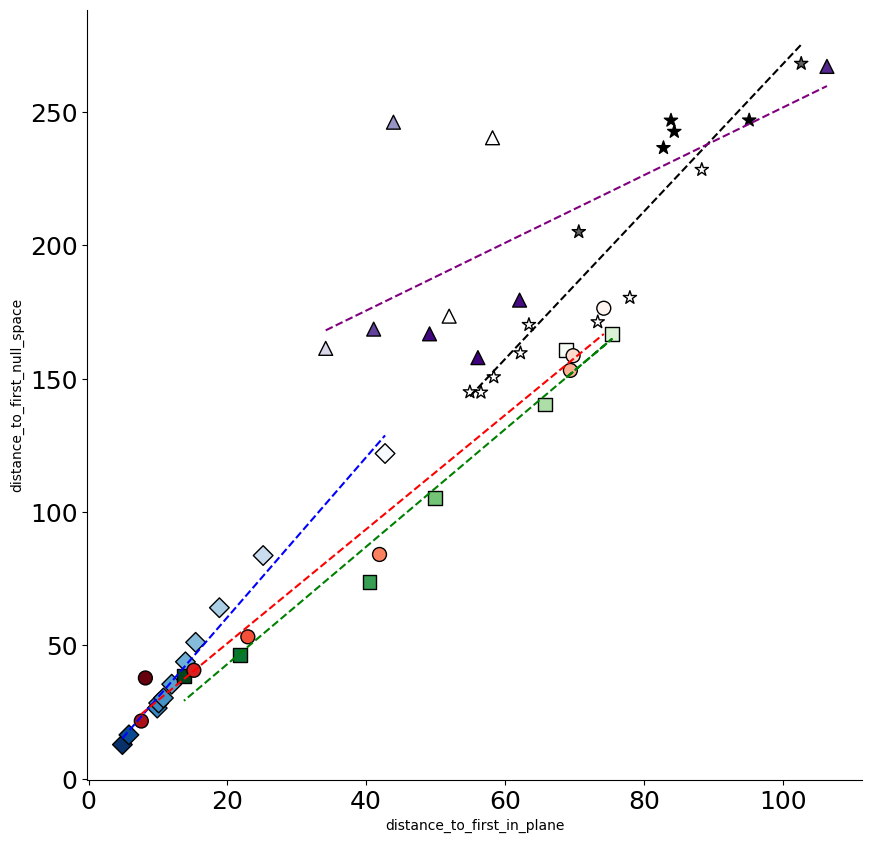

In [25]:
def get_closest_stability(avg_df, reference_stability):
    # get closest stability to reference stability
    avg_df['distance_to_reference'] = abs(avg_df['stability'] - reference_stability)
    avg_df = avg_df.sort_values(by=['distance_to_reference'])
    closest_stability = avg_df.iloc[0]
    return closest_stability


# plot distance in null vs distance in range
X = 'distance_to_first_in_plane'
Y = 'distance_to_first_null_space'

plt.figure(figsize=(10,10))

# lwf
df = combined_df_lwf[combined_df_lwf['dense_size'] == DENSE_SIZE]
df = df[df['lwf_temperature'] == LWF_TEMP]
df = df.groupby(['lwf_alpha', 'lwf_temperature']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
plt.plot(df[X], slope * df[X] + intercept, '--', c='blue')


plt.scatter(df[X],
            df[Y],
            c=df['lwf_alpha'],
            cmap='Blues',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='LwF',
            marker='D'
            )

# ewc
df = combined_df_ewc[combined_df_ewc['dense_size'] == DENSE_SIZE]
df = df.groupby(['ewc_lambda']).mean(numeric_only=True).reset_index()
slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
plt.plot(df[X], slope * df[X] + intercept, '--', c='green')
log_norm_ewc = LogNorm(vmin=df['ewc_lambda'].min(), vmax=df['ewc_lambda'].max())
plt.scatter(x=df[X],
            y=df[Y],
            c=df['ewc_lambda'],
            cmap='Greens',
            norm=log_norm_ewc,
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            marker='s',
            label='EWC',
            )

# SI
df = combined_df_si[combined_df_si['dense_size'] == DENSE_SIZE]
df = df[df['si_eps'] == SI_EPS]
df = df.groupby(['si_lambda']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
plt.plot(df[X], slope * df[X] + intercept, '--', c='red')

norm = LogNorm(vmin=df['si_lambda'].min(), vmax=df['si_lambda'].max())
plt.scatter(df[X],
            df[Y],
            c=df['si_lambda'],
            cmap='Reds',
            norm=norm,
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='SI',
            )

# gem
df = combined_df_gem[combined_df_gem['dense_size'] == DENSE_SIZE]
df = df[df['gem_memory_strength'] >= 0]
df = df.groupby(['gem_patterns_per_experience', 'gem_memory_strength']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])

# regression line
slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
plt.plot(df[X], slope * df[X] + intercept, '--', c='k')


plt.scatter(df[X],
            df[Y],
            c=df['gem_memory_strength'],
            cmap='Greys',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='GEM',
            marker='*'
            )

# replay
df = combined_df_replay[combined_df_replay['dense_size'] == DENSE_SIZE]
df = df.groupby(['replay_mem_size']).mean(numeric_only=True).reset_index()
df = df.sort_values(by=[X])
# regression line
slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
plt.plot(df[X], slope * df[X] + intercept, '--', c='purple')

plt.scatter(df[X],
            df[Y],
            c=df['replay_mem_size'],
            cmap='Purples',
            norm=LogNorm(),
            s=MARKER_SIZE,
            edgecolors='k',
            linewidths=1,
            label='Replay',
            marker='^'
            )


# plt.legend()

# axis labels
plt.xlabel(X)
plt.ylabel(Y)
# equal axes
# plt.gca().set_aspect('equal', adjustable='box')
# despine
sns.despine()

# increase size of tick font
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# x = np.linspace(0, 100, 100)
# y = np.sqrt(118/10) * x
# plt.plot(x, y, linestyle='dotted', c='k', alpha=.5)

# plt.savefig(f'{plotdir}/distance_to_first_in_plane_vs_null_space.png', bbox_inches='tight')

plt.savefig(f'{plotdir}/distance_to_first_in_plane_vs_null_space.png', bbox_inches='tight')


/var/folders/7n/wpwh80rn01z3xkb5bl7v9wyh0000gn/T/ipykernel_44233/2084229118.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['ewc_lambda']).mean().reset_index()
/var/folders/7n/wpwh80rn01z3xkb5bl7v9wyh0000gn/T/ipykernel_44233/2084229118.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['si_lambda']).mean().reset_index()
/var/folders/7n/wpwh80rn01z3xkb5bl7v9wyh0000gn/T/ipykernel_44233/2084229118.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric

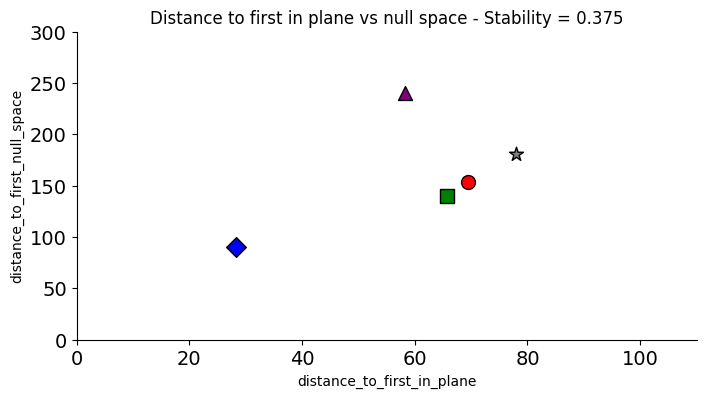

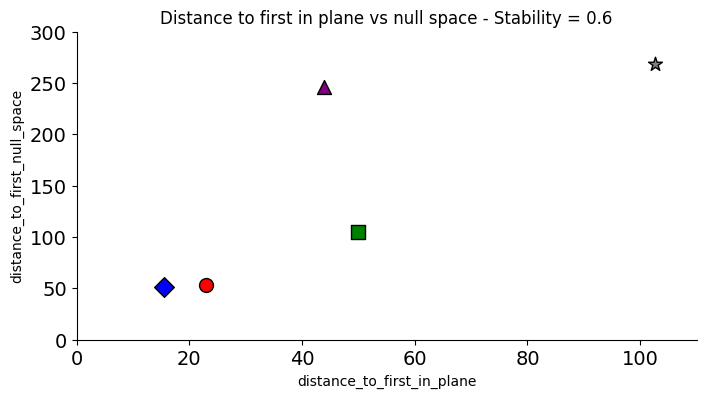

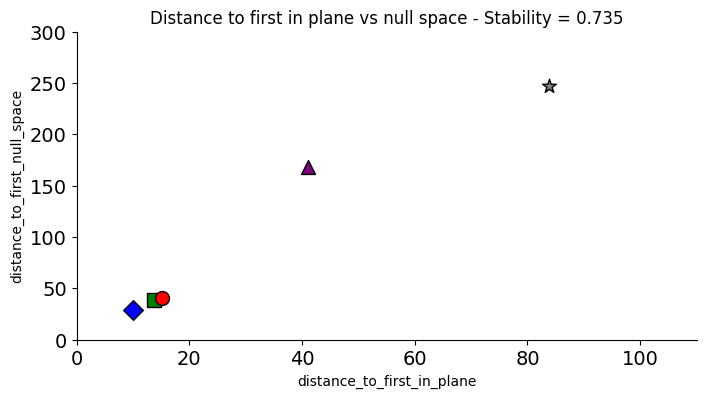

In [27]:
# for each algorithm, get closest mean stability to reference stability and parameters

def get_closest_stability(avg_df, reference_stability):
    # get closest stability to reference stability
    avg_df['distance_to_reference'] = abs(avg_df['stability'] - reference_stability)
    avg_df = avg_df.sort_values(by=['distance_to_reference'])
    closest_stability = avg_df.iloc[0]
    return closest_stability

for REFERENCE_STABILITY in REFERENCE_STABILITIES:
    # EWC
    df = combined_df_ewc[combined_df_ewc['dense_size'] == DENSE_SIZE]
    df = df.groupby(['ewc_lambda']).mean().reset_index()
    closest_stability_ewc = get_closest_stability(df, REFERENCE_STABILITY)
    # collect runs
    ewc_ref_runs = combined_df_ewc[(combined_df_ewc['dense_size'] == DENSE_SIZE) & (combined_df_ewc['ewc_lambda'] == closest_stability_ewc['ewc_lambda'])]
    # SI
    df = combined_df_si[combined_df_si['dense_size'] == DENSE_SIZE]
    df = df[df['si_eps'] == SI_EPS]
    df = df.groupby(['si_lambda']).mean().reset_index()
    closest_stability_si = get_closest_stability(df, REFERENCE_STABILITY)
    # collect runs
    si_ref_runs = combined_df_si[(combined_df_si['dense_size'] == DENSE_SIZE) & (combined_df_si['si_eps'] == SI_EPS) & (combined_df_si['si_lambda'] == closest_stability_si['si_lambda'])]
    # Replay
    df = combined_df_replay[combined_df_replay['dense_size'] == DENSE_SIZE]
    df = df.groupby(['replay_mem_size']).mean().reset_index()
    closest_stability_replay = get_closest_stability(df, REFERENCE_STABILITY)
    # collect runs
    replay_ref_runs = combined_df_replay[(combined_df_replay['dense_size'] == DENSE_SIZE) & (combined_df_replay['replay_mem_size'] == closest_stability_replay['replay_mem_size'])]
    # gem
    df = combined_df_gem[combined_df_gem['dense_size'] == DENSE_SIZE]
    df = df[df['gem_memory_strength'] >= 0]
    df = df.groupby(['gem_patterns_per_experience', 'gem_memory_strength']).mean().reset_index()
    closest_stability_gem = get_closest_stability(df, REFERENCE_STABILITY)
    # collect runs
    gem_ref_runs = combined_df_gem[(combined_df_gem['dense_size'] == DENSE_SIZE) & (combined_df_gem['gem_memory_strength'] == closest_stability_gem['gem_memory_strength']) & (combined_df_gem['gem_patterns_per_experience'] == closest_stability_gem['gem_patterns_per_experience'])]
    # lwf
    df = combined_df_lwf[combined_df_lwf['dense_size'] == DENSE_SIZE]
    df = df.groupby(['lwf_alpha', 'lwf_temperature']).mean().reset_index()
    closest_stability_lwf = get_closest_stability(df, REFERENCE_STABILITY)
    # collect runs
    lwf_ref_runs = combined_df_lwf[(combined_df_lwf['dense_size'] == DENSE_SIZE) & (combined_df_lwf['lwf_alpha'] == closest_stability_lwf['lwf_alpha']) & (combined_df_lwf['lwf_temperature'] == closest_stability_lwf['lwf_temperature'])]

    # force a copy of all dfs
    ewc_ref_runs = ewc_ref_runs.copy()
    si_ref_runs = si_ref_runs.copy()
    replay_ref_runs = replay_ref_runs.copy()
    gem_ref_runs = gem_ref_runs.copy()
    lwf_ref_runs = lwf_ref_runs.copy()

    # concatenate all runs after adding algorithm column
    ewc_ref_runs['algorithm'] = 'EWC'
    si_ref_runs['algorithm'] = 'SI'
    replay_ref_runs['algorithm'] = 'Replay'
    gem_ref_runs['algorithm'] = 'GEM'
    lwf_ref_runs['algorithm'] = 'LwF'

    # concatenate all runs
    ref_runs = pd.concat([ewc_ref_runs, si_ref_runs, replay_ref_runs, gem_ref_runs, lwf_ref_runs])
    # select algorithm and distances
    ref_runs = ref_runs[['algorithm', 'distance_to_first_null_space', 'distance_to_first_in_plane']]
    # avg over algorithm
    ref_runs = ref_runs.groupby(['algorithm']).mean().reset_index()
    plt.figure(figsize=(8,4))

    # ewc
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'EWC'][X],
        ref_runs[ref_runs['algorithm'] == 'EWC'][Y],
        c='g',
        s=MARKER_SIZE,
        marker='s',
        edgecolors='k',
        linewidths=1,
        label='EWC'
    )

    # SI
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'SI'][X],
        ref_runs[ref_runs['algorithm'] == 'SI'][Y],
        c='r',
        s=MARKER_SIZE,
        marker='o',
        edgecolors='k',
        linewidths=1,
        label='SI'
    )

    # Replay
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'Replay'][X],
        ref_runs[ref_runs['algorithm'] == 'Replay'][Y],
        c='purple',
        s=MARKER_SIZE,
        marker='^',
        edgecolors='k',
        linewidths=1,
        label='Replay'
    )

    # GEM
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'GEM'][X],
        ref_runs[ref_runs['algorithm'] == 'GEM'][Y],
        c='grey',
        s=MARKER_SIZE + 10,
        marker='*',
        edgecolors='k',
        linewidths=1,
        label='GEM'
    )

    # LwF
    plt.scatter(
        ref_runs[ref_runs['algorithm'] == 'LwF'][X],
        ref_runs[ref_runs['algorithm'] == 'LwF'][Y],
        c='blue',
        s=MARKER_SIZE,
        marker='D',
        edgecolors='k',
        linewidths=1,
        label='LwF'
    )

    # set text sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.legend(fontsize=14)

    plt.title(f'Distance to first in plane vs null space - Stability = {REFERENCE_STABILITY}')
    plt.xlabel(X)
    plt.ylabel(Y)
    sns.despine()
    # equal axes
    # plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim([0, 110])
    plt.ylim([0, 300])
    plt.savefig(f'{plotdir}/distance_to_first_in_plane_vs_null_space_stability_{REFERENCE_STABILITY}.png', bbox_inches='tight')